# DDPG

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# == recnn ==
import sys
sys.path.append("../../")
import recnn

cuda = torch.device('cuda')
# ---
frame_size = 10
batch_size = 25
# --- 

tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_embeddings_key_dict = pickle.load(open('../../data/embeddings/ml20_pca128.pkl', 'rb'))
movies_embeddings_tensor, \
key_to_id, id_to_key = recnn.data.make_items_tensor(movie_embeddings_key_dict)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = recnn.data.prepare_dataset(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


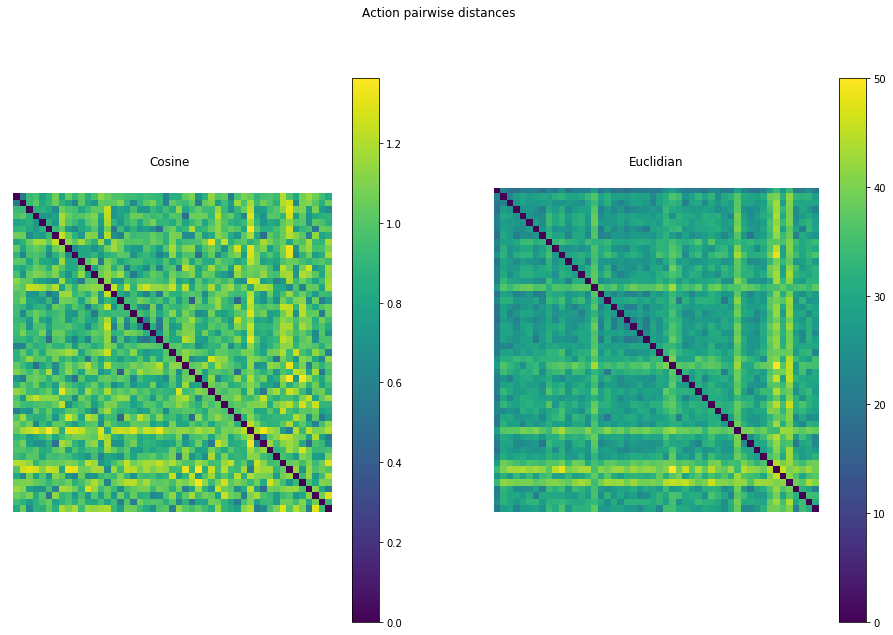

In [9]:
recnn.plot.pairwise_distances(movies_embeddings_tensor[:50])

In [10]:
class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-1):
        super(Actor, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(input_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, action_dim)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [11]:
class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-5):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(input_dim + action_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [12]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
            
def run_tests():
    test_batch = next(iter(test_dataloader))
    losses = ddpg_update(test_batch, params, learn=False, step=step)
    
    gen_actions = debugger.debug_dict['mat']['next_action']
    gen_test_actions = debugger.debug_dict['mat']['test next_action']
    true_actions = movies_embeddings_tensor.detach().cpu().numpy()
    
    f = plotter.kde_reconstruction_error(ad, gen_actions, gen_test_actions, true_actions, cuda)
    writer.add_figure('rec_error',f, losses['step'])
    return losses

In [ ]:
def ddpg_update(batch, params, learn=True, step=-1):
    batch = [i.to(cuda) for i in batch]
    state, action, reward, next_state, done = batch
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
        
    # --------------------------------------------------------#
    # Value Learning
    
    with torch.no_grad():
        next_action = target_policy_net(next_state)
        target_value   = target_value_net(next_state, next_action.detach())
        expected_value = reward + (1.0 - done) * params['gamma'] * target_value
        expected_value = torch.clamp(expected_value,
                                     params['min_value'], params['max_value'])

    value = value_net(state, action)
    
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()


    debugger.log_object('next_action', next_action, "mat", test=(not learn))
    debugger.log_error('value', value, test=(not learn))
    debugger.log_error('target_value ', target_value, test=(not learn))
    
    if learn:
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()
    else:
        writer.add_figure('next_action',
                    recnn.plot.pairwise_distances_fig(next_action[:50]), step)
        writer.add_histogram('value', value, step)
        writer.add_histogram('target_value', target_value, step)
        writer.add_histogram('expected_value', expected_value, step)
    
    # --------------------------------------------------------#
    # Policy learning
    
    gen_action = policy_net(state)
    policy_loss = -value_net(state, gen_action)
    debugger.log_object('gen_action', gen_action, test=(not learn))
    
    if not learn:
        writer.add_histogram('policy_loss', policy_loss, step)
        writer.add_figure('next_action',
                    recnn.plot.pairwise_distances_fig(gen_action[:50]), step)
    policy_loss = policy_loss.mean()
    
    if learn and step % params['policy_step']== 0:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net, target_value_net, soft_tau=params['soft_tau'])
        soft_update(policy_net, target_policy_net, soft_tau=params['soft_tau'])


    losses = {'value': value_loss.item(), 'policy': policy_loss.item(), 'step': step}
    return losses

In [33]:
# === ddpg settings ===

params = {
    'gamma'      : 0.99,
    'min_value'  : -10,
    'max_value'  : 10,
    'policy_step': 10,
    'soft_tau'   : 0.001,
    
    'policy_lr'  : 1e-5,
    'value_lr'   : 1e-5,
    'actor_weight_init': 54e-2,
    'critic_weight_init': 6e-1,
}

# === end ===

In [34]:
value_net  = Critic(1290, 128, 256, params['critic_weight_init']).to(cuda)
policy_net = Actor(1290, 128, 256, params['actor_weight_init']).to(cuda)


target_value_net = Critic(1290, 128, 256).to(cuda)
target_policy_net = Actor(1290, 128, 256).to(cuda)

ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

target_policy_net.eval()
target_value_net.eval()

soft_update(value_net, target_value_net, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = nn.MSELoss()

# from good to bad: Ranger Radam Adam RMSprop
value_optimizer = recnn.optim.Ranger(value_net.parameters(),
                              lr=params['value_lr'], weight_decay=1e-2)
policy_optimizer = recnn.optim.Ranger(policy_net.parameters(),
                               lr=params['policy_lr'], weight_decay=1e-5)

layout = {
    'test': {'value': [], 'policy': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }

writer = SummaryWriter(log_dir='../../runs')
debugger = recnn.Debugger(layout, run_tests, writer)
plotter = recnn.plot.Plotter(debugger, [['value', 'policy']],)

In [35]:
step = 1
n_epochs = 100
batch_size = 25

epoch_bar = tqdm(total=n_epochs)

train_users = users[:-5000]
test_users = users[-5000:]

def prepare_batch_wrapper(x):
    batch = recnn.data.prepare_batch_static_size(x, movies_embeddings_tensor, frame_size=frame_size)
    return batch

train_user_dataset = recnn.data.UserDataset(train_users, user_dict)
test_user_dataset = recnn.data.UserDataset(test_users, user_dict)
train_dataloader = DataLoader(train_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1,collate_fn=prepare_batch_wrapper)

step 8220


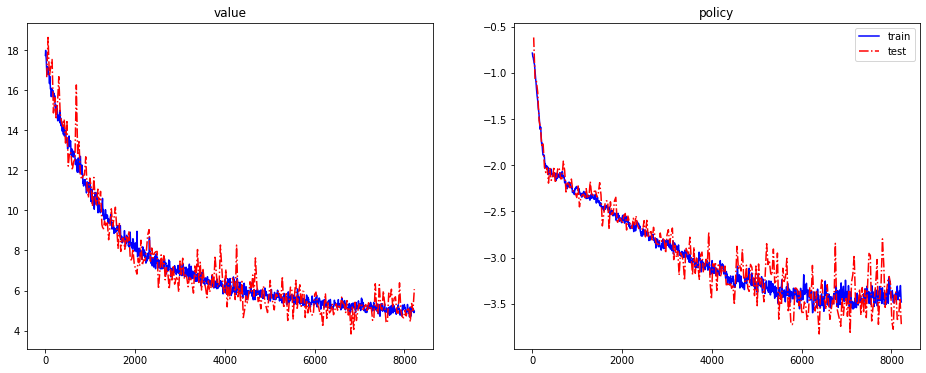

KeyboardInterrupt: 

In [36]:

# --- config ---
plot_every = 30
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for batch in tqdm(train_dataloader):
        loss = ddpg_update(batch, params, step=step)
        debugger.log_losses(loss)
        step += 1
        debugger.log_step(step)
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            debugger.test()
            plotter.plot_loss()

In [41]:
# torch.save(value_net.state_dict(), "../../models/ddpg_value.pt")
# torch.save(policy_net.state_dict(), "../../models/ddpg_policy.pt")

# Debug info

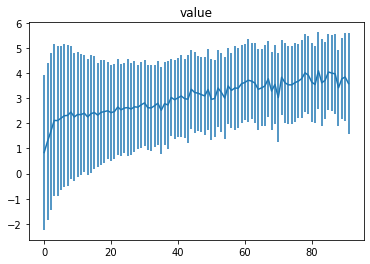

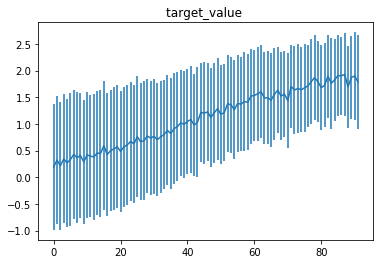

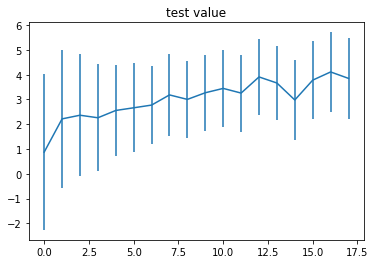

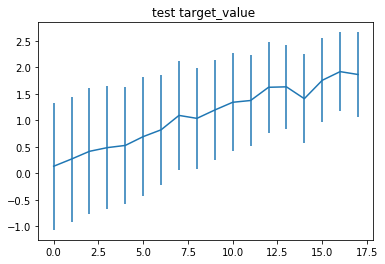

In [37]:
debugger.err_plot()

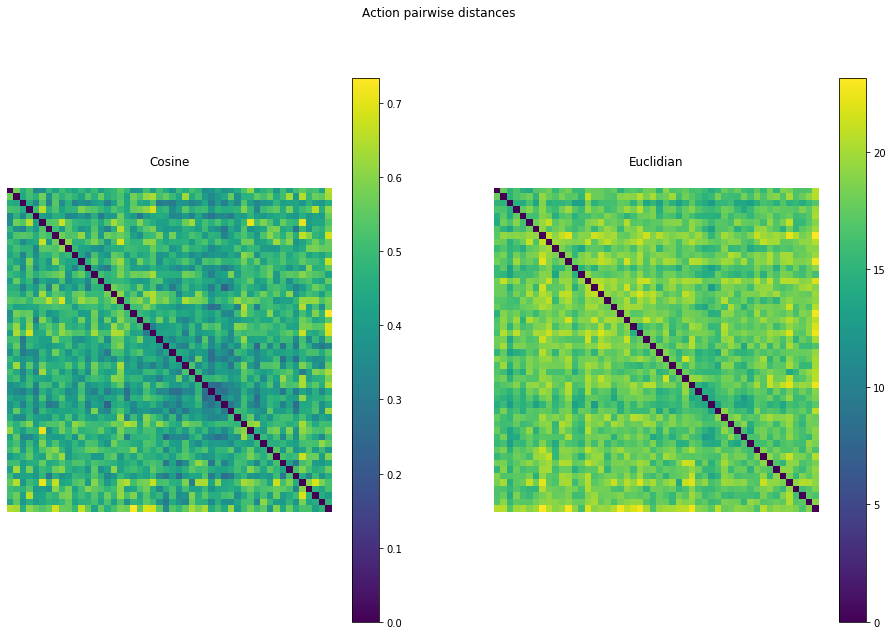

In [38]:
debugger.matshow('next_action')

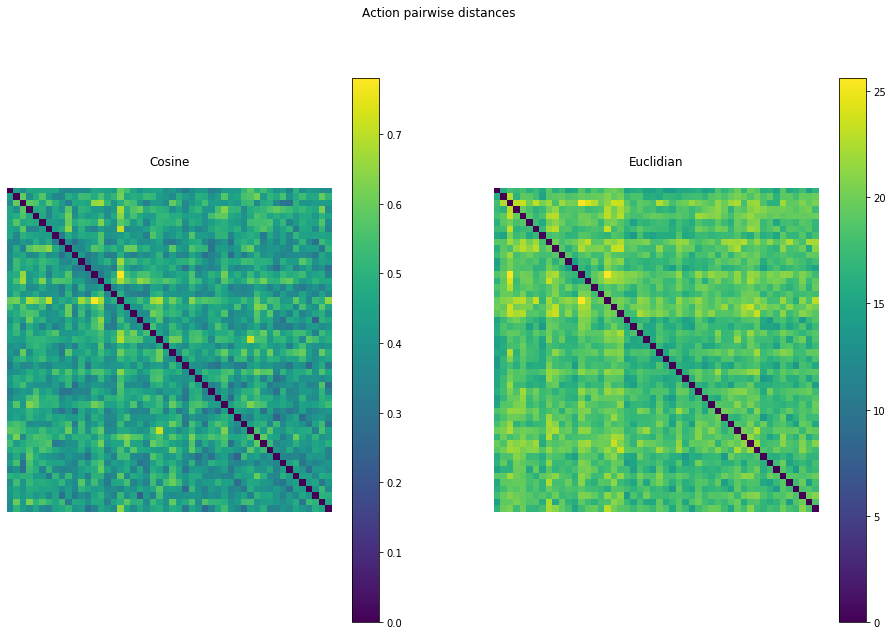

In [39]:
debugger.matshow('test next_action')

# Reconstruction error

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


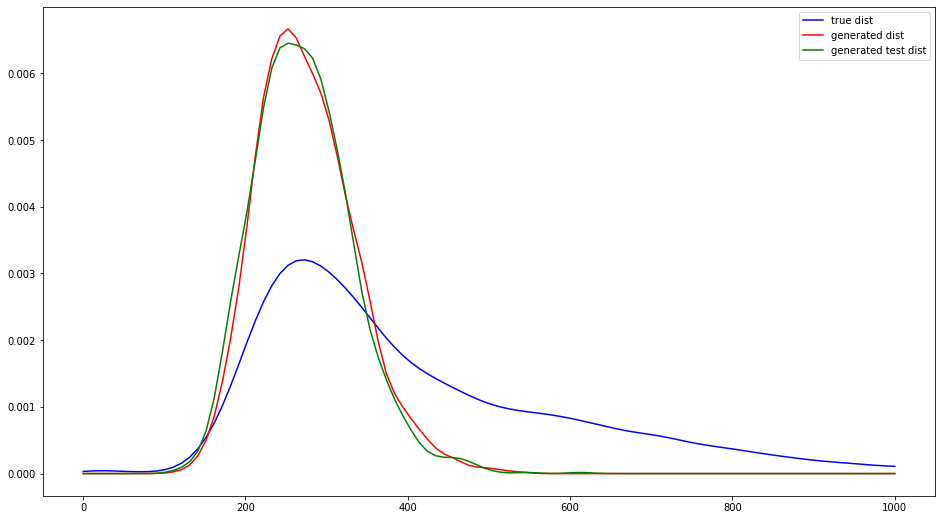

In [40]:
gen_actions = debugger.debug_dict['mat']['next_action']
gen_test_actions = debugger.debug_dict['mat']['test next_action']
true_actions = np.stack(movie_embeddings_key_dict.values())


ad = recnn.models.AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

debugger.plot_kde_reconstruction_error(ad, gen_actions, gen_test_actions, true_actions, cuda)